# 1. Data Importing

In [1]:
import arch
import holidays
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from matplotlib import pyplot

In [2]:
gold_df = pd.read_csv("data/SPDR_Gold_Shares_USD.csv")
equity_df = pd.read_csv("data/CAC40_EUR.csv")

In [3]:
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%Y-%m-%d")
gold_df.set_index("Date", inplace=True)
equity_df["Date"] = pd.to_datetime(equity_df["Date"], format="%Y-%m-%d")
equity_df.set_index("Date", inplace=True)

In [4]:
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,139.630005,12476200
2019-10-02,140.789993,141.880005,140.460007,141.259995,141.259995,11914300
2019-10-03,141.360001,143.250000,141.289993,141.899994,141.899994,12396100
2019-10-04,141.479996,142.309998,141.139999,141.899994,141.899994,9651000
2019-10-07,141.160004,141.770004,140.240005,140.690002,140.690002,6127200


In [5]:
gold_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-22,138.369995,138.460007,137.660004,137.740005,137.740005,3620300
2019-11-25,137.320007,137.619995,136.990005,137.080002,137.080002,6415800
2019-11-26,136.979996,137.800003,136.580002,137.740005,137.740005,4724400
2019-11-27,137.029999,137.210007,136.830002,137.009995,137.009995,4111000
2019-11-29,137.100006,138.130005,137.080002,137.860001,137.860001,4516400


In [6]:
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-01,5696.200195,5704.930176,5594.930176,5597.629883,5597.629883,75964100
2019-10-02,5587.140137,5589.200195,5422.770020,5422.770020,5422.770020,104451600
2019-10-03,5432.009766,5472.620117,5393.490234,5438.770020,5438.770020,83768700
2019-10-04,5456.830078,5488.319824,5426.000000,5488.319824,5488.319824,76196900
2019-10-07,5476.770020,5524.189941,5461.589844,5521.609863,5521.609863,60954000


In [7]:
equity_df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-25,5917.839844,5933.750000,5908.290039,5924.859863,5924.859863,62132600
2019-11-26,5927.410156,5941.509766,5909.930176,5929.620117,5929.620117,112044300
2019-11-27,5943.450195,5947.299805,5921.919922,5926.839844,5926.839844,68032200
2019-11-28,5909.950195,5919.129883,5900.209961,5912.720215,5912.720215,42729800
2019-11-29,5895.890137,5929.790039,5885.660156,5905.169922,5905.169922,61639300


One notable difference between gold and equity prices is that we have prices for gold ETF every day of a week while we don't have prices for equity ETF for weekends (Saturday and Sunday). In order to make the analysis comparable, we will drop the prices of gold ETF on Saturday and Sunday before making further preprocessing and analysis.

The ETF that tracks CAC 40, the France's index, traded every weekday in October and November 2019, so it is enough to drop the prices in the weekend of the gold ETF to make the data comparable.

November 28, 2019 is a Bank Holiday

In [8]:
gold_df = gold_df[gold_df.index.dayofweek < 5]

In [9]:
gold_df.shape

(43, 6)

In [10]:
equity_df.shape

(44, 6)

# 2. Data Processing

Daily returns of the gold and equity ETFs

In [11]:
gold_df["Daily Return"] = gold_df["Adj Close"].pct_change(1)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-01,138.070007,140.190002,137.800003,139.630005,139.630005,12476200,NaN
2019-10-02,140.789993,141.880005,140.460007,141.259995,141.259995,11914300,0.011674
2019-10-03,141.360001,143.250000,141.289993,141.899994,141.899994,12396100,0.004531
2019-10-04,141.479996,142.309998,141.139999,141.899994,141.899994,9651000,0.000000
2019-10-07,141.160004,141.770004,140.240005,140.690002,140.690002,6127200,-0.008527


In [12]:
equity_df["Daily Return"] = equity_df["Adj Close"].pct_change(1)
equity_df.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-01,5696.200195,5704.930176,5594.930176,5597.629883,5597.629883,75964100,NaN
2019-10-02,5587.140137,5589.200195,5422.770020,5422.770020,5422.770020,104451600,-0.031238
2019-10-03,5432.009766,5472.620117,5393.490234,5438.770020,5438.770020,83768700,0.002951
2019-10-04,5456.830078,5488.319824,5426.000000,5488.319824,5488.319824,76196900,0.009110
2019-10-07,5476.770020,5524.189941,5461.589844,5521.609863,5521.609863,60954000,0.006066


# 3. Data Summaries

In [13]:
gold_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-31,140.847391,141.384349,140.303043,140.874782,140.874782,7.757257e+06,0.000921
2019-11-30,138.611500,139.056000,138.083502,138.570500,138.570500,6.961465e+06,-0.001611


In [14]:
equity_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-31,5622.946523,5651.765243,5588.810844,5623.614746,5623.614746,8.218598e+07,0.001109
2019-11-30,5885.093820,5907.245698,5869.594773,5892.759045,5892.759045,7.542388e+07,0.001443


In [15]:
gold_df.resample('M').std()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-31,0.972620,0.929309,0.950674,0.831229,0.831229,2.804327e+06,0.006173
2019-11-30,1.618235,1.588269,1.585444,1.562095,1.562095,2.994154e+06,0.006188


In [16]:
equity_df.resample('M').std()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2019-10-31,100.552379,92.759140,108.470913,104.252663,104.252663,1.435030e+07,0.009927
2019-11-30,49.971419,44.017495,45.179099,41.017847,41.017847,1.548799e+07,0.003763


# 6. Modelling Prices

C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   23
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  81.962
Date:                Sun, 10 Jan 2021   AIC                           -155.924
Time:                        11:40:25   BIC                           -151.382
Sample:                    10-01-2019   HQIC                          -154.782
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.688      0.491      -0.001       0.002
ar.L1          0.7191      0.657      1.095      0.274      -0.568       2.007
ma.L1         -0.8619      0.636     -1.356      0.1

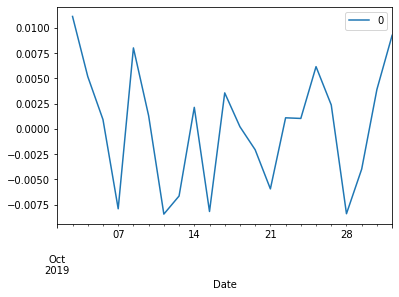

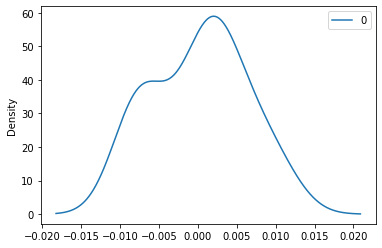

               0
count  22.000000
mean    0.000207
std     0.005978
min    -0.008440
25%    -0.005454
50%     0.001057
75%     0.003808
max     0.011117


In [17]:
# fit model
model = ARIMA(gold_df[gold_df.index < "2019-11-01"]["Daily Return"], order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                   20
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  74.368
Date:                Sun, 10 Jan 2021   AIC                           -140.737
Time:                        11:40:26   BIC                           -136.754
Sample:                             0   HQIC                          -139.959
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -1.010      0.313      -0.005       0.002
ar.L1         -0.5260      1.950     -0.270      0.787      -4.347       3.295
ma.L1          0.3870      2.223      0.174      0.8

C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python38\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

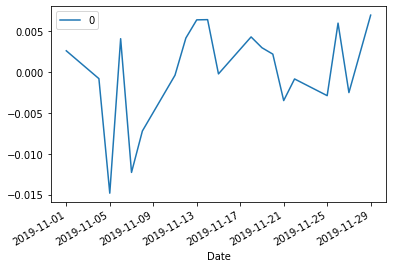

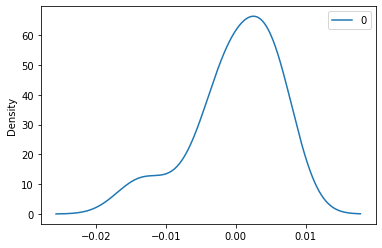

               0
count  20.000000
mean    0.000006
std     0.006022
min    -0.014835
25%    -0.002628
50%     0.000960
75%     0.004169
max     0.006936


In [18]:
# fit model
model = ARIMA(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], order=(1,0,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

# 7. Modelling Volatility

In [19]:
gold_df["High minus low"] = gold_df["High"] - gold_df["Low"]

In [20]:
gold_df.resample('M').mean()

,Open,High,Low,Close,Adj Close,Volume,Daily Return,High minus low
Date,,,,,,,,
2019-10-31,140.847391,141.384349,140.303043,140.874782,140.874782,7.757257e+06,0.000921,1.081305
2019-11-30,138.611500,139.056000,138.083502,138.570500,138.570500,6.961465e+06,-0.001611,0.972498


In [21]:
garch = arch.arch_model(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12684817.542295108
Iteration:      2,   Func. Count:     16,   Neg. LLF: -73.97790009442136
Optimization terminated successfully    (Exit mode 0)
            Current function value: -73.9779001217992
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.638e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                73.9779
Distribution:                  Normal   AIC:                          -139.956
Method:            Maximum Likelihood   BIC:                          -135.973
                                        No. Observations:                   20
Date:                Sun, Jan 10 2021   Df Residuals:                       16
Time:                        11:40:26   Df Model:                            4
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.4838e-03  7.497e-07  -1979.293      0.000 [-1.485e-03,-1.482e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.0913e-05  4.658e-11  2.343e+05      0.000 [1.091e-05,1.091e-05]
alpha[1]       0.0500      0.274      0.183      0.855     [ -0.487,  0.587]
beta[1]        0.6500      0.237      2.741  6.122e-03     [  0.185,  1.115]
============================================================================

Covariance estimator: robust
"""

In [22]:
garch = arch.arch_model(equity_df[equity_df.index >= "2019-11-01"]["Daily Return"], vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()
garch_fitted.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46717693.81309761
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1603185721.16829
Iteration:      3,   Func. Count:     29,   Neg. LLF: -88.09507064620878
Optimization terminated successfully    (Exit mode 0)
            Current function value: -88.09507071006485
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3


C:\Users\trinh\AppData\Roaming\Python\Python38\site-packages\arch\univariate\base.py:292: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.348e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           Daily Return   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:                88.0951
Distribution:                  Normal   AIC:                          -168.190
Method:            Maximum Likelihood   BIC:                          -164.012
                                        No. Observations:                   21
Date:                Sun, Jan 10 2021   Df Residuals:                       17
Time:                        11:40:26   Df Model:                            4
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.3689e-03  1.241e-07  1.103e+04      0.000 [1.369e-03,1.369e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.0449e-06  9.643e-11  4.195e+04      0.000 [4.045e-06,4.045e-06]
alpha[1]   1.0000e-02      0.125  7.997e-02      0.936     [ -0.235,  0.255]
beta[1]        0.6900      0.147      4.695  2.661e-06     [  0.402,  0.978]
============================================================================

Covariance estimator: robust
"""

In [23]:
stats.pearsonr(gold_df[gold_df.index >= "2019-11-01"]["Daily Return"], equity_df[equity_df.index >= "2019-11-01"]["Daily Return"])

ValueError: x and y must have the same length.